In [1]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from began.visualization import radians, degrees, cos
from scipy.ndimage import gaussian_filter

ImportError: cannot import name 'radians' from 'began.visualization' (/home/bthorne/projects/gan/began/src/began/visualization.py)

In [19]:
def mplot(ma, extent=None, title=None, cbar_range=None):
    try:
        assert ma.ndim == 3
    except AssertionError:
        raise AssertionError("Number of dimensions must be three")

    nma = ma.shape[0]

    if cbar_range is not None:
        (vmin, vmax) = cbar_range
    else:
        vmin, vmax = None, None
    
    if nma <= 3:
        fig, axes = plt.subplots(1, nma, sharey=True, figsize=(4 * nma, 4))

    else:
        nplot = np.round(np.sqrt(nma)).astype(int)
        fig, axes = plt.subplots(nrows=nplot, ncols=nplot, sharex=True, sharey=True, figsize=(4 * nplot, 4 * nplot))
 
    plt.subplots_adjust(top=0.9, bottom=0.1)
    
    for i, ax in enumerate(axes.flatten()):
        im = plot(ma[i], extent=extent, ax=ax, ret_im=True, imshow_kw={'vmin': vmin, 'vmax': vmax})
        
    if cbar_range is not None:
        cb_ax = fig.add_axes([0.33, 0.03, 0.3, 0.05])
        fig.colorbar(im, cax=cb_ax, orientation='horizontal', cmap=plt.cm.coolwarm)
        
    if title is not None:
        fig.suptitle(title, y=0.935)
    return fig, axes


def plot(ma, fig=None, ax=None, extent=None, title=None, ret_im=False, cbar=False, imshow_kw={}):
    try:
        assert ma.ndim == 2
    except AssertionError:
        raise AssertionError("Number of dimensions must be two")
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    if title is not None:
        ax.set_title(title)
    ax.tick_params(axis='both', direction='in')
    im = ax.imshow(ma, extent=extent, interpolation='nearest', origin='lower', cmap=plt.cm.coolwarm, **imshow_kw)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(direction='in', length=4, width=1, colors='k')
    if not ret_im:
        return fig
    return im

As an example we will take the minimization of a quadratic function from the Tensorflow Probability page.

In [4]:
# A high-dimensional quadratic bowl.
ndims = 60
minimum = np.ones([ndims], dtype='float64')
scales = np.arange(ndims, dtype='float64') + 1.0

# The objective function and the gradient.
def quadratic_loss_and_gradient(x):
    return tfp.math.value_and_gradient(
        lambda x: tf.reduce_sum(
        scales * tf.math.squared_difference(x, minimum), axis=-1),
        x)
start = np.arange(ndims, 0, -1, dtype='float64')
optim_results = tfp.optimizer.lbfgs_minimize(
    quadratic_loss_and_gradient,
    initial_position=start,
    num_correction_pairs=10,
    tolerance=1e-8)

# Check that the search converged
assert(optim_results.converged)
# Check that the argmin is close to the actual value.
np.testing.assert_allclose(optim_results.position, minimum)

In [5]:
print(optim_results.position)

tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], shape=(60,), dtype=float64)


Now we do a version with a loss function involving a tensorflow model

In [6]:
gen = tf.keras.models.load_model("/home/bthorne/projects/gan/began/models/generator.h5")

In [7]:
def get_L2_loss_and_gradient_function(ma, generator):
    def L2_loss_and_gradient(x):
        with tf.GradientTape() as tape:
            tape.watch(x)
            loss = tf.linalg.norm(generator(x) - ma)
        jac = tape.gradient(loss, x)
        loss_value = tf.reshape(loss, [1])
        return loss_value, jac
    return L2_loss_and_gradient

In [8]:
z_in = np.random.randn(1, 64)
ma = gen(z_in)

fwhm_in_pix = 120. / 5.
sigma = fwhm_in_pix / np.sqrt(8 * np.log(2))
print('Sigma:', sigma)
ma_smo = gaussian_filter(ma[0, :, :, 0], sigma)

Sigma: 10.191861603456228


In [9]:
l2 = get_L2_loss_and_gradient_function(ma_smo, gen)

In [10]:
x = tf.Variable(np.random.randn(1, 64), dtype=np.float32)
opt = tfp.optimizer.lbfgs_minimize(l2, initial_position=x, max_iterations=20000, tolerance=1e-08)

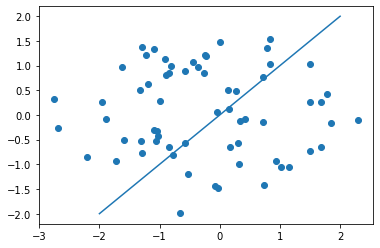

In [11]:
fig, ax = plt.subplots(1, 1)
ax.scatter(z_in, opt.position.numpy())
ax.plot(np.linspace(-2, 2), np.linspace(-2, 2))

In [12]:
gen_smo_prediction = gen(opt.position)

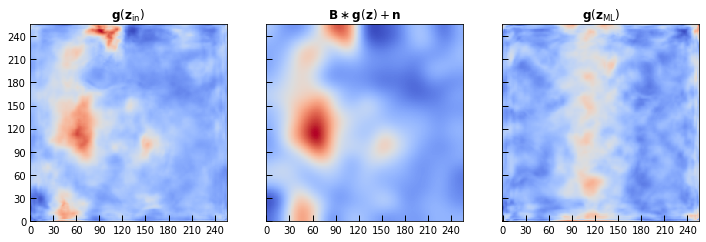

In [18]:
fig, axes = mplot(np.concatenate((ma[..., 0], ma_smo[None, ...], gen_smo_prediction[..., 0])))
titles = [r"$\mathbf{g}(\mathbf{z_{\rm in}})$", r"$\mathbf{B} \ast \mathbf{g}(\mathbf{z}) + \mathbf{n}$", r"$\mathbf{g}(\mathbf{z}_{\rm ML})$"]
for ax, title in zip(axes, titles):
    ax.set_title(title)
fig.savefig("plots/hyper-res-rec-g.pdf")

In [14]:
import h5py
from pathlib import Path

In [15]:
#for my maps
#RES = 256
#STEP_SIZE = 4 
#GAL_CUT = 16
#record_dir = Path("../data/preprocessed/")
#fpath = record_dir / "GNILC_dust_map_{:d}_st{:d}_gcut{:d}.npy".format(RES, int(STEP_SIZE), int(GAL_CUT))
#train_images = np.load(fpath).astype(np.float32)
#x_train = train_images[21, :, :, 0]

# for kevin's maps

with h5py.File("/home/bthorne/projects/gan/began/data/preprocessed/Planck_dust_cuts_353GHz_norm_log_res256.h5", 'r') as f:
    x_train = f['100'][:]

x_train_smo = gaussian_filter(x_train, sigma)

In [45]:
l2 = get_L2_loss_and_gradient_function(x_train_smo, gen)
x = tf.Variable(np.random.randn(1, 64), dtype=np.float32)
opt = tfp.optimizer.lbfgs_minimize(l2, initial_position=x, max_iterations=20000, tolerance=1e-05)
x_train_prediction = gen(opt.position)
x_train_prediction_smo = gaussian_filter(x_train_prediction[0, :, :, 0], sigma)

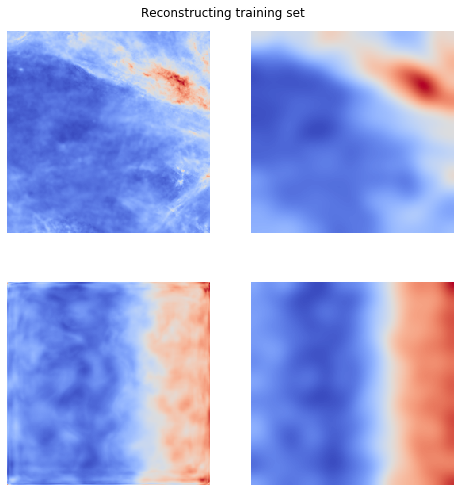

In [46]:
fig, axes = mplot(np.concatenate((x_train[None, ...], x_train_smo[None, ...], x_train_prediction[..., 0], x_train_prediction_smo[None, ...])),  title="Reconstructing training set")
for ax in axes.flatten():
    ax.axis('off')

In [47]:
print(opt.num_iterations)
print(opt.converged)
print(opt.position)

tf.Tensor(568, shape=(), dtype=int32)
tf.Tensor([ True], shape=(1,), dtype=bool)
tf.Tensor(
[[ 0.7777661   0.35785067 -0.66485894 -0.93533707  0.74035025 -0.19816683
   1.4072828   0.40942478  0.9197596  -0.10675532  0.9442109  -0.46784356
  -0.49820098  0.07216769  0.84894615 -0.86517626  0.05362741 -0.8082499
   0.7325236  -0.43028343  0.4924435   0.2416315  -0.32671642 -0.7906038
  -0.79810876  0.36320576  1.3923523  -0.560927   -0.06386184 -0.58188194
   1.438536   -1.3459064  -0.00811598 -0.45585093  0.6587306   1.337751
   0.15895857 -0.25583982  1.5774226  -0.23664948 -0.6549841   0.38459012
  -1.1786913   1.4341394   1.3472599   0.9801018   0.31807262  0.34710634
  -0.06088901  1.1855452   0.18773046 -0.0874474  -0.4219793   0.5936553
  -0.05380261  0.9171325  -0.02387524  1.4238207  -0.392952    0.45000833
  -0.48083594 -0.8464603   0.13555042 -0.7596523 ]], shape=(1, 64), dtype=float32)


(array([ 0.,  0.,  0.,  0.,  1.,  5., 15., 16., 13.,  6.,  8.,  0.,  0.,
         0.,  0.]),
 array([-4.        , -3.4666667 , -2.9333334 , -2.4       , -1.8666667 ,
        -1.3333334 , -0.8       , -0.26666668,  0.26666668,  0.8       ,
         1.3333334 ,  1.8666667 ,  2.4       ,  2.9333334 ,  3.4666667 ,
         4.        ], dtype=float32),
 <a list of 15 Patch objects>)

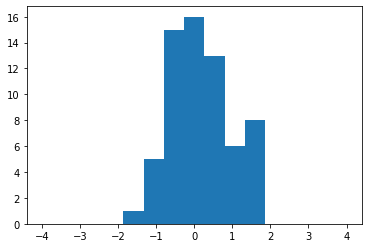

In [48]:
plt.hist(opt.position, range=[-4, 4], bins=15)

In [25]:
import h5py

with h5py.File("/home/bthorne/projects/gan/began/data/preprocessed/Planck_dust_cuts_353GHz_norm_log_res256.h5", 'r') as f:
    kma = f['1'][:]

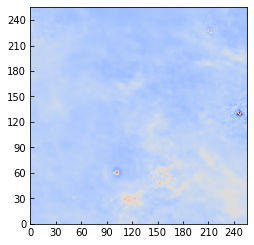

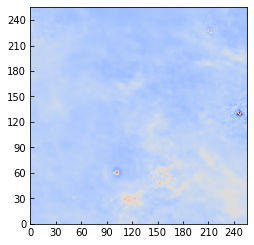

In [26]:
plot(kma)

In [29]:
import began
LAT_DIM = 128
vae_model = began.CVAE(LAT_DIM)


In [30]:
vae_model.load_weights('/home/bthorne/projects/gan/began/models/vae.h5')

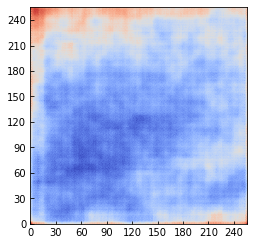

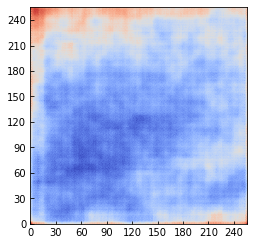

In [37]:
plot(vae_model.decode(np.random.randn(1, 128).astype(np.float32))[0, :, :, 0])

In [38]:
z_enc = vae_model.encode(x_train[None, :, :, None])

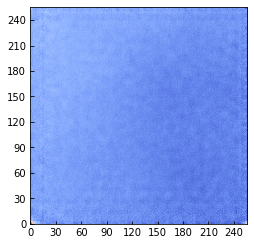

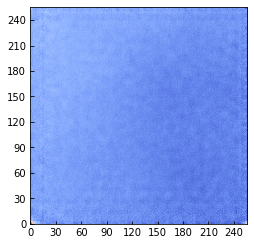

In [39]:
plot(vae_model.decode(z_enc)[0, :, :, 0])